In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 이미지 처리
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# json 파일 다루기
import json

In [4]:
# 파일 존재 여부 확인용
import os

In [5]:
# 훈련용 데이터와 검증용 데이터 분리
from sklearn.model_selection import train_test_split

In [6]:
# 딥러닝 모델로 예측진행
from tensorflow import keras

# 디렉토리 설정

In [7]:
os.chdir('/content/drive/MyDrive/[perst]데이터셋/MachineLearningProject/01_Cloth Detection Model')

In [8]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1IE_8n95r-2qLINUcooIi9SdGkw55753B/[perst]데이터셋/MachineLearningProject/01_Cloth Detection Model'

# 변수 목록

In [9]:
# 사용할 이미지 개수
img_file_size = 2000

# 크기 조정 사이즈
res_width = 200
res_height = 200

ori_img_dir_name = "./Dataset/Original/Image/" # 원본 이미지 파일이 존재하는 디릭토리명
ori_json_dir_name = "./Dataset/Original/Json/" # 원본 json 파일이 존재하는 디렉토리명

train_dir_name = "./Dataset/Train-Test_Multiple/Train/" # Train 데이터를 저장할 디렉토리명
test_dir_name = "./Dataset/Train-Test_Multiple/Test/" # Test 데이터를 저장할 디렉토리명

In [10]:
# 배경제거에 사용되는 모델
model_path = "./Model/binary_poly_seg_model_0113_01.keras"

# 반복실행용 변수

In [11]:
# end_read_point = 0
# end_save_point_train = 0
# end_save_point_test = 0

In [12]:
end_read_point = 8000
end_save_point_train = 6400
end_save_point_test = 1600

In [13]:
start_read_point = end_read_point + 1
start_save_point_train = end_save_point_train + 1
start_save_point_test = end_save_point_test + 1

In [14]:
print('End Read Point : ' + str(end_read_point))
print('Start Read Point : ' + str(start_read_point))
print()
print('End Save Point (Train) : ' + str(end_save_point_train))
print('Start Save Point (Train) : ' + str(start_save_point_train))
print()
print('End Save Point (Test) : ' + str(end_save_point_test))
print('Start Save Point (Test) : ' + str(start_save_point_test))

End Read Point : 8000
Start Read Point : 8001

End Save Point (Train) : 6400
Start Save Point (Train) : 6401

End Save Point (Test) : 1600
Start Save Point (Test) : 1601


# 데이터 불러오기

In [15]:
dataset_list = []
read_point = start_read_point - 1

while (len(dataset_list) < img_file_size):
  read_point = read_point + 1

  img_path = ori_img_dir_name + str(read_point) + ".jpg"
  json_path = ori_json_dir_name + str(read_point) + ".json"

  # 해당 숫자의 파일이 없으면 다음 숫자 뽑기
  if not os.path.isfile(img_path):
    continue
  if not os.path.isfile(json_path):
    continue

  tmp_list = []

  # 이미지 파일 로드
  img_file = cv2.imread(img_path)
  if img_file is None:
    print(str(read_point) + ".jpg File Load Failed!!")
    break

  # json 파일 로드
  with open(json_path, "r") as loadfile:
    json_file = json.load(loadfile)
    if json_file is None:
      print(str(read_point) + ".json File Load Failed!!")
      break

  tmp_list.append(img_file)
  tmp_list.append(json_file)

  dataset_list.append(tmp_list)
  end_read_point = read_point

  if ((len(dataset_list))%500) == 0: # 진행도 체크용
    print(str(len(dataset_list)) + "개 파일 읽어오기 완료")

print()
print("Complete")
print("End Read Point : " + str(end_read_point))

500개 파일 읽어오기 완료
1000개 파일 읽어오기 완료
1500개 파일 읽어오기 완료
2000개 파일 읽어오기 완료

Complete
End Read Point : 10001


In [16]:
len(dataset_list)

2000

In [17]:
len(dataset_list[0])

2

# 폴리곤 좌표에서 라벨링 마스크 생성

## 함수

In [18]:
# 폴리곤 좌표로 라벨링 마스크를 그리는 함수
# 입력 형태: json 파일 통째로
# 출력 형태: 라벨링된 마스크 이미지

def poly_to_mask(json_dict):
    # 빈 마스크 생성
    img_mask = np.zeros((json_dict['Img_Height'], json_dict['Img_Width']))

    # 세그멘테이션 영역 이름 리스트
    part_list = list(json_dict['Poly_Seg'].keys())

    for part in part_list:
        if part == 'Outer':
            mask_pts = np.array(json_dict['Poly_Seg'][part], np.int32)
            cv2.fillPoly(img_mask, [mask_pts], 1)
        if part == 'Top':
            mask_pts = np.array(json_dict['Poly_Seg'][part], np.int32)
            cv2.fillPoly(img_mask, [mask_pts], 2)
        if part == 'Bottom':
            mask_pts = np.array(json_dict['Poly_Seg'][part], np.int32)
            cv2.fillPoly(img_mask, [mask_pts], 3)
        if part == 'Onepiece':
            mask_pts = np.array(json_dict['Poly_Seg'][part], np.int32)
            cv2.fillPoly(img_mask, [mask_pts], 4)

    # Float 형식을 Int 형식으로 변경
    img_mask = img_mask.astype('uint8')

    return img_mask


## 적용

In [19]:
# dataset_list[i][2]에 세그멘테이션 이미지를 저장
# dataset_list[i][0]은 원본 이미지, [1]은 json, [2]는 마스크 이미지

for data in dataset_list:
    data.append(poly_to_mask(data[1]))

print("Complete")

Complete


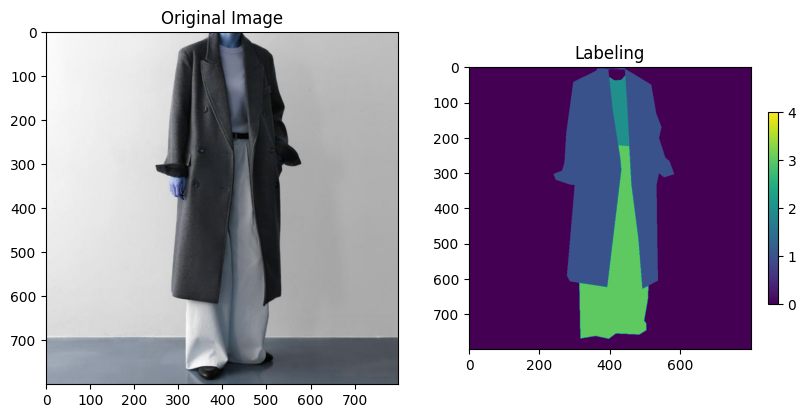

In [20]:
# 리스트 형태 확인
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(dataset_list[0][0])
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(dataset_list[0][2])
plt.clim(0, 4)
plt.colorbar(shrink=0.5)
plt.title("Labeling")

plt.show()

# 이미지 크기 조정 및 배경 제거

## 이미지 크기 조정

In [21]:
res_img_sample = cv2.resize(dataset_list[0][0], dsize=(res_height, res_width), interpolation=cv2.INTER_AREA)
res_mask_sample = cv2.resize(dataset_list[0][2], dsize=(res_height, res_width), interpolation=cv2.INTER_NEAREST)

In [22]:
np.unique(res_mask_sample)

array([0, 1, 2, 3], dtype=uint8)

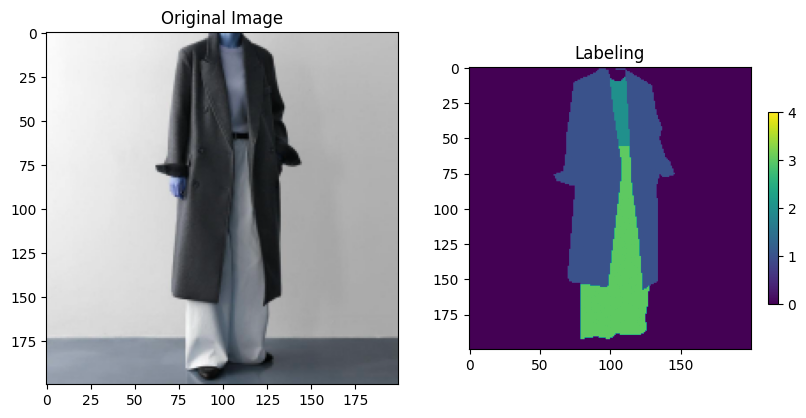

In [23]:
# 리스트 형태 확인
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(res_img_sample)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(res_mask_sample)
plt.clim(0, 4)
plt.colorbar(shrink=0.5)
plt.title("Labeling")

plt.show()

## 배경 제거

In [24]:
# 예측을 위해 numpy 형태로 변경

sample_x = np.array(res_img_sample)
res_img_sample.shape

(200, 200, 3)

In [25]:
sample_list = [sample_x]
sample_list = np.array(sample_list)
sample_list.shape

(1, 200, 200, 3)

In [26]:
# 예측 진행

seg_model = keras.models.load_model(model_path)

preds = seg_model.predict(sample_list)

1/1 [==============================] - 1s 588ms/step


In [27]:
sample_mask = np.ndarray.round(preds[0])
sample_mask = sample_mask.astype('uint8')

np.unique(sample_mask)

array([0, 1], dtype=uint8)

In [28]:
len(np.unique(sample_mask))

2

In [29]:
1 not in np.unique(sample_mask)

False

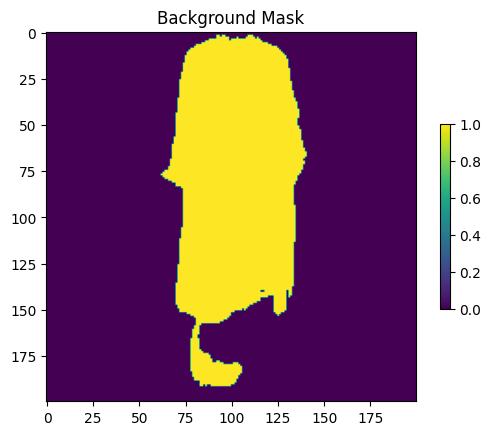

In [30]:
plt.imshow(sample_mask)
plt.clim(0, 1)
plt.colorbar(shrink=0.5)
plt.title("Background Mask")

plt.show()

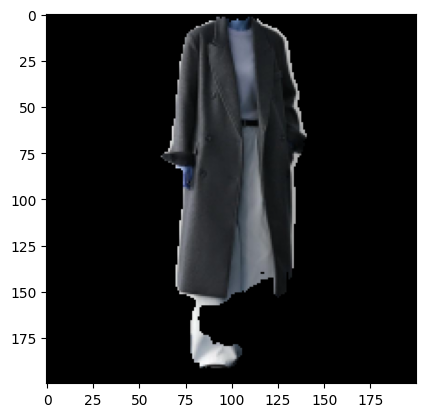

In [31]:
# 마스크를 원본 이미지에 적용
sample_crop = cv2.bitwise_and(res_img_sample, res_img_sample, mask=sample_mask)

plt.imshow(sample_crop)
plt.show()

## 전체 이미지 크기 조정 및 배경 제거

### 크기 조정

In [32]:
for data in dataset_list:
    data[0] = cv2.resize(data[0], dsize=(res_height, res_width), interpolation=cv2.INTER_AREA)
    data[2] = cv2.resize(data[2], dsize=(res_height, res_width), interpolation=cv2.INTER_NEAREST)

print("Complete")

Complete


### 배경 제거

In [33]:
# 예측용 x 이미지 생성

img_x = []

for data in dataset_list:
    np_img = np.array(data[0])
    img_x.append(np_img)

img_x = np.array(img_x)
print(img_x.shape)

(2000, 200, 200, 3)


In [34]:
# 예측 진행

# seg_model = keras.models.load_model(model_path)
preds = seg_model.predict(img_x)

print("Complete")

63/63 [==============================] - 593s 9s/step
Complete


In [35]:
# 예측 결과를 마스크로 생성하고 원본 이미지에 적용

for i in range(0, len(preds)):
    mask = np.ndarray.round(preds[i])
    mask = mask.astype('uint8')

    # 이미지 영역 전체가 마스크 처리됐을 경우
    if (1 not in np.unique(mask)):
      dataset_list[i][0] = cv2.flip(dataset_list[i-1][0], 1) # 1은 좌우반전, 0은 상하반전
    else:
      dataset_list[i][0] = cv2.bitwise_and(dataset_list[i][0], dataset_list[i][0], mask=mask)

print("Complete")

Complete


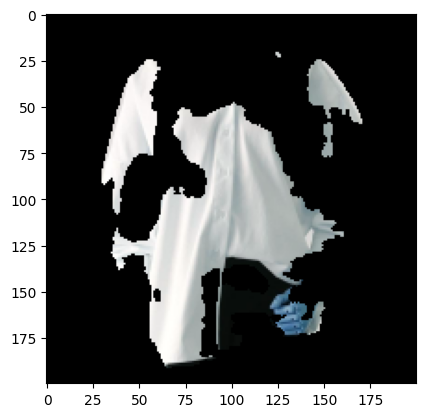

In [36]:
plt.imshow(dataset_list[1000][0])
plt.show()

# 변경된 이미지에 맞추어 Json 파일값 조정

## 이미지 Width, Height 정보 수정 및 렉트 좌표값 정보 삭제

In [37]:
dataset_list[0][1].keys()

dict_keys(['Img_Width', 'Img_Height', 'Rect_Seg', 'Poly_Seg'])

In [38]:
for data in dataset_list:
    data[1]['Img_Width'] = res_width
    data[1]['Img_Height'] = res_height
    del data[1]['Rect_Seg']

print("Complete")

Complete


In [39]:
dataset_list[0][1]

{'Img_Width': 200,
 'Img_Height': 200,
 'Poly_Seg': {'Top': [[389, 24],
   [403, 115],
   [417, 235],
   [459, 239],
   [457, 121],
   [445, 22],
   [431, 37],
   [412, 38],
   [389, 23]],
  'Bottom': [[417, 221],
   [425, 274],
   [426, 319],
   [387, 614],
   [313, 607],
   [316, 769],
   [359, 762],
   [396, 770],
   [416, 755],
   [483, 758],
   [502, 746],
   [502, 727],
   [496, 719],
   [507, 656],
   [508, 613],
   [494, 616],
   [494, 546],
   [473, 414],
   [459, 225]],
  'Outer': [[366, 3],
   [358, 12],
   [296, 42],
   [276, 187],
   [271, 271],
   [264, 294],
   [240, 303],
   [246, 319],
   [285, 332],
   [300, 334],
   [278, 592],
   [286, 607],
   [391, 623],
   [431, 291],
   [428, 258],
   [407, 122],
   [399, 49],
   [394, 6],
   [442, 2],
   [449, 108],
   [457, 262],
   [461, 333],
   [481, 488],
   [492, 628],
   [535, 605],
   [533, 484],
   [531, 334],
   [538, 300],
   [553, 312],
   [581, 303],
   [568, 267],
   [556, 257],
   [538, 201],
   [545, 170],
   [5

# Train-Test Split

In [40]:
# 8:2 비율로 train-test split
train, test = train_test_split(dataset_list, test_size=0.2) # stratify, random_state 설정 가능

In [41]:
len(train)

1600

In [42]:
len(test)

400

# 좌표 정보 통계

## Train 데이터 좌표 정보 통계

In [43]:
seg_check_list = []

for i in range(0, len(train)):
    seg_name_list = list(train[i][1]['Poly_Seg'].keys())

    seg_check_list.append(seg_name_list)

    if ((i+1)%100) == 0: # 진행도 체크용
        print(str(i+1) + "개 정보 읽어오기 완료")


seg_count = {}

for item in seg_check_list:
    if str(item) not in seg_count: # 해당 키가 없을 경우
        seg_count[str(item)] = 1
    else:
        seg_count[str(item)] = seg_count[str(item)]+1


seg_count = sorted(seg_count.items(), key= lambda item:item[1], reverse=True)

seg_count_labels = []
seg_count_values = []

for item in seg_count:
    seg_count_labels.append(item[0])
    seg_count_values.append(item[1])


print("Complete")

100개 정보 읽어오기 완료
200개 정보 읽어오기 완료
300개 정보 읽어오기 완료
400개 정보 읽어오기 완료
500개 정보 읽어오기 완료
600개 정보 읽어오기 완료
700개 정보 읽어오기 완료
800개 정보 읽어오기 완료
900개 정보 읽어오기 완료
1000개 정보 읽어오기 완료
1100개 정보 읽어오기 완료
1200개 정보 읽어오기 완료
1300개 정보 읽어오기 완료
1400개 정보 읽어오기 완료
1500개 정보 읽어오기 완료
1600개 정보 읽어오기 완료
Complete


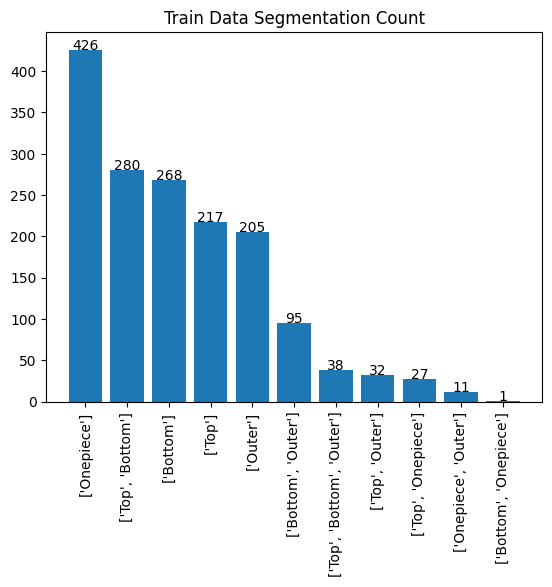

In [44]:
barplot = plt.bar(seg_count_labels, seg_count_values)
plt.xticks(rotation=90)

for i, j in enumerate(barplot) :
    plt.text(i, j.get_height() + 0.5, seg_count_values[i], ha = 'center')

plt.title("Train Data Segmentation Count")
plt.show()

In [45]:
total = np.sum(seg_count_values)
seg_count_labels_ratio = []

for i in range(0, len(seg_count_labels)):
    ratio = (seg_count_values[i]/total) * 100

    new_label = seg_count_labels[i] + (' %.1f%%' % ratio)
    seg_count_labels_ratio.append(new_label)

print("Complete")

Complete


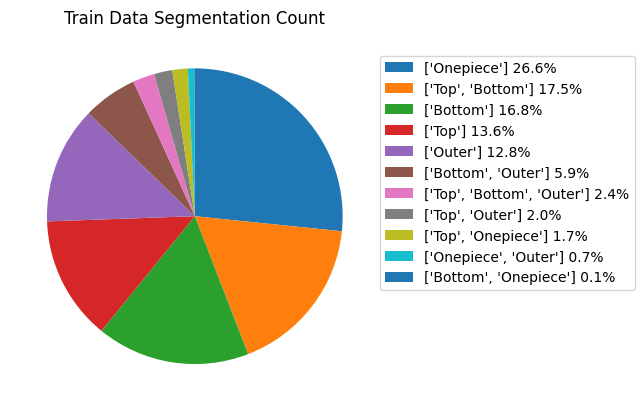

In [46]:
plt.pie(seg_count_values, startangle=90, counterclock=False)

plt.title("Train Data Segmentation Count")
plt.legend(seg_count_labels_ratio, loc=(1.0, 0.3))
plt.show()

## Test 데이터 좌표 정보 통계

In [47]:
seg_check_list = []

for i in range(0, len(test)):
    seg_name_list = list(test[i][1]['Poly_Seg'].keys())

    seg_check_list.append(seg_name_list)

    if ((i+1)%100) == 0: # 진행도 체크용
        print(str(i+1) + "개 정보 읽어오기 완료")


seg_count = {}

for item in seg_check_list:
    if str(item) not in seg_count: # 해당 키가 없을 경우
        seg_count[str(item)] = 1
    else:
        seg_count[str(item)] = seg_count[str(item)]+1


seg_count = sorted(seg_count.items(), key= lambda item:item[1], reverse=True)

seg_count_labels = []
seg_count_values = []

for item in seg_count:
    seg_count_labels.append(item[0])
    seg_count_values.append(item[1])


print("Complete")

100개 정보 읽어오기 완료
200개 정보 읽어오기 완료
300개 정보 읽어오기 완료
400개 정보 읽어오기 완료
Complete


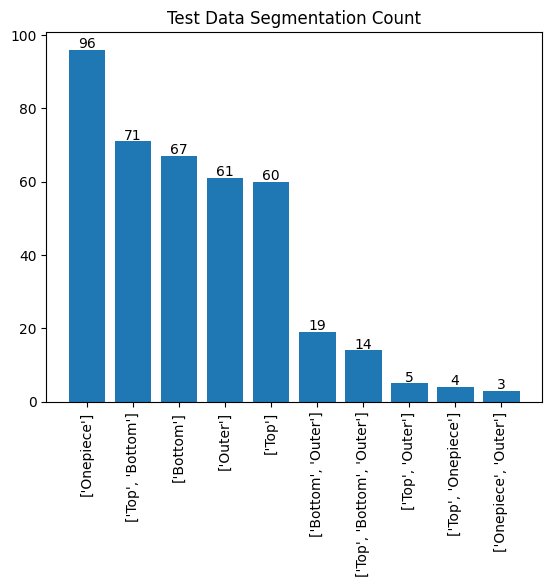

In [48]:
barplot = plt.bar(seg_count_labels, seg_count_values)
plt.xticks(rotation=90)

for i, j in enumerate(barplot) :
    plt.text(i, j.get_height() + 0.5, seg_count_values[i], ha = 'center')

plt.title("Test Data Segmentation Count")
plt.show()

In [49]:
total = np.sum(seg_count_values)
seg_count_labels_ratio = []

for i in range(0, len(seg_count_labels)):
    ratio = (seg_count_values[i]/total) * 100

    new_label = seg_count_labels[i] + (' %.1f%%' % ratio)
    seg_count_labels_ratio.append(new_label)

print("Complete")

Complete


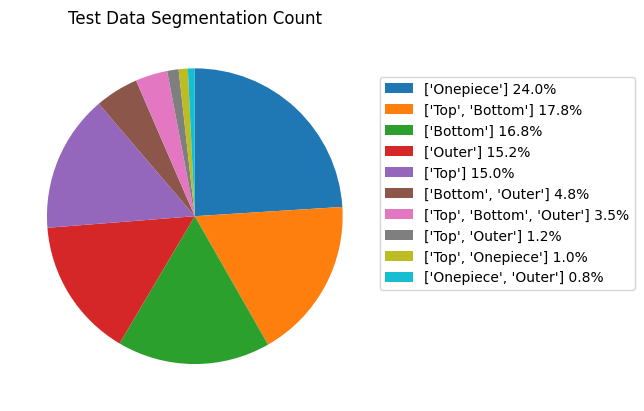

In [50]:
plt.pie(seg_count_values, startangle=90, counterclock=False)

plt.title("Test Data Segmentation Count")
plt.legend(seg_count_labels_ratio, loc=(1.0, 0.3))
plt.show()

# 학습용 데이터를 X와 Y로 구분

In [51]:
x_train = []
json_train = []
poly_train = []

for data in train:
    x_train.append(data[0])
    json_train.append(data[1])
    poly_train.append(data[2])

print("Complete")

Complete


In [52]:
x_test = []
json_test = []
poly_test = []

for data in test:
    x_test.append(data[0])
    json_test.append(data[1])
    poly_test.append(data[2])

print("Complete")

Complete


# 학습용 데이터를 폴더에 저장

In [53]:
palette = [0,0,0,
          255,0,0,
          0,255,0,
          0,0,255,
          255,255,0]

In [54]:
i = start_save_point_train

for img in x_train:
    success = cv2.imwrite(train_dir_name + "Image/" + str(i) + ".jpg", img)

    if not success:
        print("Image Save Failed!!")
        break

    i = i+1

print("Complete")

Complete


In [55]:
i = start_save_point_train

for mask in poly_train:
    png_mask = Image.fromarray(mask).convert('P')
    png_mask.putpalette(palette)

    mask_path = train_dir_name + "Annotation/" + str(i) + ".png"
    png_mask.save(mask_path)

    if not os.path.isfile(mask_path):
        print("Image Save Failed!!")
        break

    i = i+1

print("Complete")

Complete


In [56]:
i = start_save_point_train

for json_file in json_train:
    json_path = train_dir_name + "Json/" + str(i) + ".json"

    with open(json_path, 'w') as outfile:
        json.dump(json_file, outfile)

    if not os.path.isfile(json_path): # 파일 저장에 실패했을 경우
        print("Json Save Failed!!")
        break

    end_save_point_train = i
    i = i+1

print("Complete")

Complete


In [57]:
i = start_save_point_test

for img in x_test:
    success = cv2.imwrite(test_dir_name + "Image/" + str(i) + ".jpg", img)

    if not success:
        print("Image Save Failed!!")
        break

    i = i+1

print("Complete")

Complete


In [58]:
i = start_save_point_test

for mask in poly_test:
    png_mask = Image.fromarray(mask).convert('P')
    png_mask.putpalette(palette)

    mask_path = test_dir_name + "Annotation/" + str(i) + ".png"
    png_mask.save(mask_path)

    if not os.path.isfile(mask_path):
        print("Image Save Failed!!")
        break

    i = i+1

print("Complete")

Complete


In [59]:
i = start_save_point_test

for json_file in json_test:
    json_path = test_dir_name + "Json/" + str(i) + ".json"

    with open(json_path, 'w') as outfile:
        json.dump(json_file, outfile)

    if not os.path.isfile(json_path): # 파일 저장에 실패했을 경우
        print("Json Save Failed!!")
        break

    end_save_point_test = i
    i = i+1

print("Complete")

Complete


# 실제 폴더 확인